In [1]:
%cd /Users/Pracioppo/Desktop/VPTR/VPTR/

C:\Users\Pracioppo\Desktop\VPTR\VPTR


In [2]:
import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from pathlib import Path
import random
from datetime import datetime

import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Loading bar
from PIL import Image

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import get_dataloader
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training
from utils import set_seed
from utils import f_rescale_dataset, f_Residuals, f_reshape_training_data, f_rotate_and_zoom, f_random_crop, f_rotate_and_zoom_all, f_crop_all, f_flip_all, f_augment_dataset2

from utils import KTHDataset, BAIRDataset, MovingMNISTDataset

set_seed(2023)

import argparse

import cv2
from tabulate import tabulate

In [3]:
ckpt_save_dir = Path('Y:/FAZ/Healthy/all_Healthy/Models/FAZ_ckpt')
tensorboard_save_dir = Path('Y:/FAZ/Healthy/all_Healthy/Models/FAZ_tensorboard')

start_epoch = 0

resume_ckpt = None

summary_writer = SummaryWriter(tensorboard_save_dir.absolute().as_posix())

In [4]:
parser = argparse.ArgumentParser('SINDy NN')
args = parser.parse_args(args=[])

In [5]:
args.num_past_frames = 1
args.num_future_frames = 1
args.encH, args.encW, args.encC = 16, 16, 128 # Increased dimensions for 512 x 512 images
args.img_channels = 1 #3 channels for BAIR datset
args.epochs = 10

args.N = 10

args.AE_lr = 2e-4

args.batch_size = args.N
test_past_frames = 1
test_future_frames = 1

In [6]:
import torch
print(torch.__version__)

2.0.1


In [7]:
torch.cuda.is_available()

True

In [8]:
args.device = torch.device('cuda:0')
# args.device = torch.device('cpu')
print(f"Using {args.device} device")

Using cuda:0 device


## Load in Data

### Healthy Data

In [9]:
from torch.utils.data import Dataset, DataLoader, random_split

class Data(Dataset):
    pass

train_data = Data()
val_data = Data()
test_data = Data()

In [10]:
# N = 10
# Nv = N
# batch_size = N
# ngpus = 1
# num_workers = 1

In [11]:
# %cd Y:/FAZ/Healthy/all_Healthy/extras/mats

# Imgs_SVC_aug = torch.from_numpy(sio.loadmat('Imgs_SVC_aug.mat')["Imgs_SVC"].astype(np.float32))
# FakeMasks_SVC_aug = torch.from_numpy(sio.loadmat('Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))

# Imgs_DVC_aug = torch.from_numpy(sio.loadmat('Imgs_DVC_aug.mat')["Imgs_DVC"].astype(np.float32))
# FakeMasks_DVC_aug = torch.from_numpy(sio.loadmat('Masks_DVC_aug.mat')["Masks_DVC"].astype(np.float32))

# Imgs_SVC_aug = Imgs_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
# FakeMasks_SVC_aug = Masks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
# Imgs_DVC_aug = Imgs_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
# FakeMasks_DVC_aug = Masks_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)

### Photocoagulation data

In [12]:
%cd Y:/FAZ/Photocoagulation/Laser and Mask - All-orig-extractedImages/mats

Photocoag_Imgs_aug = torch.from_numpy(sio.loadmat('Imgs_aug.mat')["Imgs"].astype(np.float32))
Photocoag_Masks_aug = torch.from_numpy(sio.loadmat('Real_Masks_aug.mat')["Masks"].astype(np.float32))

Y:\FAZ\Photocoagulation\Laser and Mask - All-orig-extractedImages\mats


### Healthy Data

In [13]:
%cd Y:\FAZ\FAZ-cropped-SVC-graded\Healthy\all_Healthy\PR\mats

Healthy_Imgs_SVC_aug = torch.from_numpy(sio.loadmat('Imgs_SVC_aug.mat')["Imgs_SVC"].astype(np.float32))
# Healthy_FakeMasks_SVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))
Healthy_RealMasks_SVC_aug = torch.from_numpy(sio.loadmat('Real_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))

Healthy_Imgs_DVC_aug = torch.from_numpy(sio.loadmat('Imgs_DVC_aug.mat')["Imgs_DVC"].astype(np.float32))
Healthy_FakeMasks_DVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_DVC_aug.mat')["Masks_DVC"].astype(np.float32))

Healthy_Imgs_SVC_aug = Healthy_Imgs_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
# Healthy_FakeMasks_SVC_aug = Healthy_FakeMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
Healthy_RealMasks_SVC_aug = Healthy_RealMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
Healthy_Imgs_DVC_aug = Healthy_Imgs_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
Healthy_FakeMasks_DVC_aug = Healthy_FakeMasks_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)

Y:\FAZ\FAZ-cropped-SVC-graded\Healthy\all_Healthy\PR\mats


### ALZ data

In [14]:
%cd Y:\FAZ\FAZ-cropped-SVC-graded\Alz\all_Alz\PR\mats
    
ALZ_Imgs_SVC_aug = torch.from_numpy(sio.loadmat('Imgs_SVC_aug.mat')["Imgs_SVC"].astype(np.float32))
# ALZ_FakeMasks_SVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))
ALZ_RealMasks_SVC_aug = torch.from_numpy(sio.loadmat('Real_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))

ALZ_Imgs_DVC_aug = torch.from_numpy(sio.loadmat('Imgs_DVC_aug.mat')["Imgs_DVC"].astype(np.float32))
ALZ_FakeMasks_DVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_DVC_aug.mat')["Masks_DVC"].astype(np.float32))

ALZ_Imgs_SVC_aug = ALZ_Imgs_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
# ALZ_FakeMasks_SVC_aug = ALZ_FakeMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
ALZ_RealMasks_SVC_aug = ALZ_RealMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
ALZ_Imgs_DVC_aug = ALZ_Imgs_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
ALZ_FakeMasks_DVC_aug = ALZ_FakeMasks_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)

Y:\FAZ\FAZ-cropped-SVC-graded\Alz\all_Alz\PR\mats


### AMD data

In [15]:
%cd Y:\FAZ\FAZ-cropped-SVC-graded\AMD\all_AMD\PR\mats

AMD_Imgs_SVC_aug = torch.from_numpy(sio.loadmat('Imgs_SVC_aug.mat')["Imgs_SVC"].astype(np.float32))
# AMD_FakeMasks_SVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))
AMD_RealMasks_SVC_aug = torch.from_numpy(sio.loadmat('Real_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))

AMD_Imgs_DVC_aug = torch.from_numpy(sio.loadmat('Imgs_DVC_aug.mat')["Imgs_DVC"].astype(np.float32))
AMD_FakeMasks_DVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_DVC_aug.mat')["Masks_DVC"].astype(np.float32))

AMD_Imgs_SVC_aug = AMD_Imgs_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
# AMD_FakeMasks_SVC_aug = AMD_FakeMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
AMD_RealMasks_SVC_aug = AMD_RealMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
AMD_Imgs_DVC_aug = AMD_Imgs_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
AMD_FakeMasks_DVC_aug = AMD_FakeMasks_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)

Y:\FAZ\FAZ-cropped-SVC-graded\AMD\all_AMD\PR\mats


### DR data

In [16]:
%cd Y:\FAZ\FAZ-cropped-SVC-graded\DR\all_DR\PR\mats
    
DR_Imgs_SVC_aug = torch.from_numpy(sio.loadmat('Imgs_SVC_aug.mat')["Imgs_SVC"].astype(np.float32))
# DR_FakeMasks_SVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))
DR_RealMasks_SVC_aug = torch.from_numpy(sio.loadmat('Real_Masks_SVC_aug.mat')["Masks_SVC"].astype(np.float32))

DR_Imgs_DVC_aug = torch.from_numpy(sio.loadmat('Imgs_DVC_aug.mat')["Imgs_DVC"].astype(np.float32))
DR_FakeMasks_DVC_aug = torch.from_numpy(sio.loadmat('Fake_Masks_DVC_aug.mat')["Masks_DVC"].astype(np.float32))

DR_Imgs_SVC_aug = DR_Imgs_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
# DR_FakeMasks_SVC_aug = DR_FakeMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
DR_RealMasks_SVC_aug = DR_RealMasks_SVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
DR_Imgs_DVC_aug = DR_Imgs_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)
DR_FakeMasks_DVC_aug = DR_FakeMasks_DVC_aug.unsqueeze(1).unsqueeze(1).to(args.device)

Y:\FAZ\FAZ-cropped-SVC-graded\DR\all_DR\PR\mats


### Domain Adapter

In [17]:
class Sum_Domain_Adapter(nn.Module):
    def __init__(self, num_tasks, dim, args):
        super(Sum_Domain_Adapter, self).__init__()
        
        L1 = int(dim/2)
        L2 = dim
        L3 = 2*dim
#         self.l1 = nn.Linear(num_tasks, L1).to(args.device)
#         self.l2 = nn.Linear(L1, L1).to(args.device)
#         self.l3 = nn.Linear(L1, L2).to(args.device)
        
        self.l1 = nn.Linear(num_tasks, L1).to(args.device)
        self.l2 = nn.Linear(L1, L2).to(args.device)
        self.l3 = nn.Linear(L2, L3).to(args.device)
        self.l4 = nn.Linear(L3, L2).to(args.device)
        
        self.ReLU = nn.ReLU()
        
    def forward(self, feats, one_hot_enc): 

        a1 = self.l1(one_hot_enc)
        a2 = self.ReLU(a1)
        a3 = self.l2(a2)
        a4 = self.ReLU(a3)

#         x1_f = self.l3(a4)
        a5 = self.l3(a4)
        a6 = self.ReLU(a5)
        x1_f = self.l4(a6) + a4

        x0_a = feats.flatten(start_dim=2)
        x0_b = torch.swapaxes(x0_a,1,2)

        sum1 = torch.swapaxes(x1_f + x0_b,1,2)

        return sum1.reshape(feats.size())

In [18]:
## See https://stackoverflow.com/questions/75189397/getting-the-query-key-and-value-matrices-from-pytorch-with-self-attn-in-proj-we
class Head_Domain_Adapter(nn.Module):
    def __init__(self, num_tasks, dim, nhead, args):
        super(Head_Domain_Adapter, self).__init__()
        
        self.nhead = nhead
        
        head_dim = int(dim/nhead)
        
        self.l1 = nn.Linear(num_tasks, int(head_dim/4)).to(args.device)
        self.l2 = nn.Linear(int(head_dim/4), int(head_dim/2)).to(args.device)
        self.l3 = nn.Linear(int(head_dim/2), head_dim).to(args.device)
        
        self.mha1 = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, batch_first=True).to(args.device)
        
        self.ReLU = nn.ReLU()
        self.SM = nn.Softmax(dim=1)
        
    def forward(self, feats, one_hot_enc):
        
        dim = feats.size()[1]
        num_embed = feats.size()[-1]*feats.size()[-2]
        head_dim = int(dim/self.nhead)
        
        a1 = self.l1(one_hot_enc)
        a2 = self.ReLU(a1)
        a3 = self.l2(a2)
        a4 = self.ReLU(a3)
        a5 = self.l3(a4)
        mask = self.SM(a5)

        # Query, key, and value matrices
        q_w, k_w, v_w = torch.split(self.mha1.in_proj_weight, [dim, dim, dim])
        q_b, k_b, v_b = torch.split(self.mha1.in_proj_bias, [dim, dim, dim])

        q_w = q_w.T
        k_w = k_w.T
        v_w = v_w.T

        x_a = feats.flatten(start_dim=2)
        x_b = torch.swapaxes(x_a,1,2)
        x_f = f_pos_encoding_additive(x_b,args).squeeze()

        qp = x_f @ q_w + q_b
        kp = x_f @ k_w + k_b
        vp = x_f @ v_w + v_b

        qpp = qp.reshape(args.batch_size, num_embed, self.nhead, head_dim).transpose(1, 2)
        kpp = kp.reshape(args.batch_size, num_embed, self.nhead, head_dim).transpose(1, 2)
        vpp = vp.reshape(args.batch_size, num_embed, self.nhead, head_dim).transpose(1, 2)

        ap = self.SM(qpp @ kpp.transpose(-1, -2) / np.sqrt(head_dim))
        pp = ap @ vpp
        
        prod = mask.unsqueeze(2)*pp
        prod_t = prod.transpose(1, 2).reshape(args.batch_size, num_embed, dim)
        op = self.mha1.out_proj(prod_t).transpose(1, 2)

        return op.reshape(feats.size())

In [19]:
class Dot_Product_Domain_Adapter(nn.Module):
    def __init__(self, num_tasks, dim, nhead, args):
        super(Dot_Product_Domain_Adapter, self).__init__()
        
        self.l1 = nn.Linear(num_tasks, int(dim/2)).to(args.device)
        self.l2 = nn.Linear(int(dim/2), int(dim/2)).to(args.device)
        self.l3 = nn.Linear(int(dim/2), dim).to(args.device)
        
        self.mha1 = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, batch_first=True).to(args.device)
        
        self.ReLU = nn.ReLU()
        
    def forward(self, feats, one_hot_enc):
        
        a1 = self.l1(one_hot_enc)
        a2 = self.ReLU(a1)
        a3 = self.l2(a2)
        a4 = self.ReLU(a3)
        mask = self.l3(a4)

        # Query, key, and value matrices
        q_w, k_w, v_w = torch.split(self.mha1.in_proj_weight, [dim, dim, dim])
        q_b, k_b, v_b = torch.split(self.mha1.in_proj_bias, [dim, dim, dim])

        q_w = q_w.T
        k_w = k_w.T
        v_w = v_w.T

        x_a = feats.flatten(start_dim=2)
        x_b = torch.swapaxes(x_a,1,2)
        x_f = f_pos_encoding_additive(x_b,args).squeeze()

        qp = mask @ q_w + q_b
        kp = x_f @ k_w + k_b
        vp = x_f @ v_w + v_b

        qpp = qp.reshape(args.batch_size, 1, self.nhead, head_dim).transpose(1, 2)
        kpp = kp.reshape(args.batch_size, num_embed, self.nhead, head_dim).transpose(1, 2)
        vpp = vp.reshape(args.batch_size, num_embed, self.nhead, head_dim).transpose(1, 2)

        ap = self.SM(qpp @ kpp.transpose(-1, -2) / np.sqrt(head_dim))
        pp = ap @ vpp
        
#         prod = mask.unsqueeze(2)*pp
#         prod_t = prod.transpose(1, 2).reshape(args.batch_size, num_embed, dim)
#         op = self.mha1.out_proj(prod_t).transpose(1, 2)
        
        return out.reshape(feats.size())

In [20]:
class Full_Domain_Adapter(nn.Module):
    def __init__(self, num_tasks, dim, nhead, args):
        super(Full_Domain_Adapter, self).__init__()
        
        self.DA_s = Sum_Domain_Adapter(num_tasks, dim, args)
#         self.DA_sp = Simple_Domain_Adapter(num_tasks, dim, num_t, args)
#         self.DA_p = Prod_Domain_Adapter(num_tasks, dim, args)
#         self.DA_dp = Dot_Product_Domain_Adapter(num_tasks, dim, nhead, args)
#         self.DA_h = Head_Domain_Adapter(num_tasks, dim, nhead, args)
        
    def forward(self, feats, one_hot_enc):
        
        a3 = self.DA_s(feats, one_hot_enc)
#         a3 = self.DA_p(feats, one_hot_enc)

#         a1 = self.DA_s(feats, one_hot_enc)
#         a3 = self.DA_sp(a1, one_hot_enc)
        
#         a1 = self.DA_s(feats, one_hot_enc)
#         a3 = self.DA_dp(a1, one_hot_enc)
        
#         a1 = self.DA_s(feats, one_hot_enc)
#         a2 = self.DA_h(feats, one_hot_enc)
#         a3 = a1 + a2
    
#         a1 = self.DA_s(feats, one_hot_enc)
#         a2 = self.DA_dp(a1, one_hot_enc)
#         a3 = self.DA_h(a2, one_hot_enc)
        
        return a3

In [21]:
class Domain_Adapter_lin_v1(nn.Module):
    def __init__(self, num_tasks, dim, args):
        super(Domain_Adapter_lin_v1, self).__init__()
        
        self.l1 = nn.Linear(num_tasks, int(dim/2)).to(args.device)
        self.l2 = nn.Linear(int(dim/2), int(dim/2)).to(args.device)
        self.l3 = nn.Linear(int(dim/2), dim).to(args.device)
        
        self.ReLU = nn.ReLU()
        
    def forward(self, feats, one_hot_enc):

        a1 = self.l1(one_hot_enc.squeeze())
        a2 = self.ReLU(a1)
        a3 = self.l2(a2)
        a4 = self.ReLU(a3)
        mask = self.l3(a4)

        return mask*feats

In [22]:
class Domain_Adapter_lin_v2(nn.Module):
    def __init__(self, num_tasks, dim, args):
        super(Domain_Adapter_lin_v2, self).__init__()
        
        self.l1 = nn.Linear(num_tasks, int(dim/2)).to(args.device)
        self.l2 = nn.Linear(int(dim/2), int(dim/2)).to(args.device)
        self.l3 = nn.Linear(int(dim/2), dim).to(args.device)
        
        self.ReLU = nn.ReLU()
        self.Sigmoid = Sigmoid()
#         self.Tanh = Tanh()
        
    def forward(self, feats, one_hot_enc):

        a1 = self.l1(one_hot_enc.squeeze())
        a2 = self.ReLU(a1)
        a3 = self.l2(a2)
        a4 = self.ReLU(a3)
        a5 = self.l3(a4)
        mask = self.Sigmoid(a5)

        return mask*feats, mask

In [23]:
# Train_Data = Healthy_Imgs_SVC_aug
# Target_Data = Healthy_RealMasks_SVC_aug

# enc_base = Enc_base

# args.num_batches = int(len(Train_Data)/args.N)

# ea = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(args.device) # output: 136x136x256

# random_idxs = np.arange(len(Train_Data))
# np.random.shuffle(random_idxs)
# train_data_shuffle = Train_Data[random_idxs]
# target_data_shuffle = Target_Data[random_idxs]

# epoch_losses = np.zeros(args.num_batches)

# it = 0

# in_frames = train_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]
# target_frames = target_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]

# feats0u, feats1u, feats2u, feats3u_f, feats4u_f, x4_sz = enc_base(in_frames, one_hot_enc)

In [24]:
# feats = feats2u
# num_tasks = 2

# dim = feats.size()[1]
# num_embed = feats.size()[-1]*feats.size()[-2]
# head_dim = int(dim/args.nhead)

# mha1 = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, batch_first=True).to(args.device)

# l1 = nn.Linear(num_tasks, int(dim/2)).to(args.device)
# l2 = nn.Linear(int(dim/2), int(dim/2)).to(args.device)
# l3 = nn.Linear(int(dim/2), dim).to(args.device)

# ReLU = nn.ReLU()
# SM = nn.Softmax(dim=1)
        
# ones = torch.ones(args.batch_size,1,args.num_tasks).to(args.device)
# one_hot_f = ones*one_hot_enc

# a1 = l1(one_hot_f)
# a2 = ReLU(a1)
# a3 = l2(a2)
# a4 = ReLU(a3)
# mask = l3(a4)

# x_a = feats.flatten(start_dim=2)
# x_b = torch.swapaxes(x_a,1,2)
# x_f = f_pos_encoding_additive(x_b,args).squeeze()

# q_w, k_w, v_w = torch.split(mha1.in_proj_weight, [dim, dim, dim])
# q_b, k_b, v_b = torch.split(mha1.in_proj_bias, [dim, dim, dim])

# q_w = q_w.T
# k_w = k_w.T
# v_w = v_w.T

# qp = mask @ q_w + q_b
# kp = x_f @ k_w + k_b
# vp = x_f @ v_w + v_b

# qpp = qp.reshape(args.batch_size, 1, nhead, head_dim).transpose(1, 2)
# kpp = kp.reshape(args.batch_size, num_embed, nhead, head_dim).transpose(1, 2)
# vpp = vp.reshape(args.batch_size, num_embed, nhead, head_dim).transpose(1, 2)

# ap = SM(qpp @ kpp.transpose(-1, -2) / np.sqrt(head_dim))
# pp = ap @ vpp
# pp.size()

# prod = mask.unsqueeze(2)*pp
# prod_t = prod.transpose(1, 2).reshape(args.batch_size, num_embed, dim)
# op = self.mha1.out_proj(prod_t).transpose(1, 2)


In [25]:
# feats4u_f.size()

# e1 = nn.Conv2d(512, 256, kernel_size=1, padding=0).to(args.device)

# feats2u.size()
# e1(feats2u).size()

# x4_sz[1] = x4_sz[1]/2

### Net Architectures

In [32]:
class Compress_Im_feats(torch.nn.Module):
    """
    Compress img feats
    """

    # Initialize the network and specify input/output dimensions:
    def __init__(self, args, dim1, dim2, dim3):
        super(Compress_Im_feats, self).__init__()
    
        self.h_enc1 = nn.Linear(dim1, dim2).to(args.device)
        self.h_enc2 = nn.Linear(dim2, dim2).to(args.device)
        self.h_enc3 = nn.Linear(dim2, dim2).to(args.device)
        self.h_enc4 = nn.Linear(dim2, dim3).to(args.device)

        self.ReLU = nn.ReLU()

     # Build the network:
    def forward(self, in_feats):

        a3 = self.h_enc1(in_feats)
        a4 = self.ReLU(a3)
        a5 = self.h_enc2(a4)
        a6 = self.ReLU(a5)
        a7 = self.h_enc3(a6)
        a8 = self.ReLU(a7)
        a9 = self.h_enc4(a8)
        
        return a9

In [38]:
class Unet_Enc_base(nn.Module):
    def __init__(self, nhead, args):
        super(Unet_Enc_base, self).__init__()

        self.Enc1 = VPTREnc(1, feat_dim = args.d_attn0, n_downsampling = 2).to(args.device)

        self.ea0 = nn.Conv2d(args.d_attn0, args.d_attn1, kernel_size=4, stride=4, padding=0).to(args.device)

#         self.te0u_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn0, nhead=nhead, dim_feedforward=args.d_attn1, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        
        self.e0 = nn.Conv2d(args.d_attn1, args.d_attn2, kernel_size=3, padding=1).to(args.device) # output: 136x136x256
        self.pool0 = nn.MaxPool2d(kernel_size=4, stride=4).to(args.device) # output: 68x68x256

        self.te1u_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn1, nhead=nhead, dim_feedforward=args.d_attn1, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        self.te1u_2 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn1, nhead=nhead, dim_feedforward=args.d_attn1, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)

        self.e1 = nn.Conv2d(args.d_attn2, args.d_attn2*2, kernel_size=3, padding=1).to(args.device) # output: 138x138x256
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(args.device) # output: 68x68x256

        self.te2u_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn2, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        self.te2u_2 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn2, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)

        self.e2 = nn.Conv2d(args.d_attn2*2, args.d_attn2*2, kernel_size=3, padding=1).to(args.device) # output: 138x138x256
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(args.device) # output: 68x68x256

        self.C1 = Compress_Im_feats(args, dim1=args.d_attn2*2, dim2 = 256, dim3 = 256).to(args.device)

        self.DA0 = Sum_Domain_Adapter(args.num_tasks, args.d_attn0, args)
#         self.DA1 = Sum_Domain_Adapter(args.num_tasks, args.d_attn1, args)
#         self.DA2 = Sum_Domain_Adapter(args.num_tasks, args.d_attn2, args)
#         self.DA0 = Full_Domain_Adapter(args.num_tasks, args.d_attn0, nhead, args)
        self.DA1 = Full_Domain_Adapter(args.num_tasks, args.d_attn1, nhead, args)
        self.DA2 = Full_Domain_Adapter(args.num_tasks, args.d_attn2, nhead, args)

        self.DA_l3 = Domain_Adapter_lin_v1(args.num_tasks, args.d_attn2*2, args)
    
    def forward(self, in_frames, one_hot_enc):

        feats0u = self.Enc1(in_frames).squeeze()
#         feats0u_a = feats0u.flatten(start_dim=2)
#         feats0u_a = torch.swapaxes(feats0u_a,1,2)
#         feats0u_a = f_pos_encoding_additive(feats0u_a,args).squeeze()
#         q1 = self.te0u_1(feats0u_a)
#         q2 = torch.swapaxes(q1,1,2)
#         feats0u = feats0u + q2.reshape(feats0u.size())

        feats0u = self.DA0(feats0u,one_hot_enc)

        feats1u = self.ea0(feats0u)
    
        feats1u = self.DA1(feats1u,one_hot_enc)

        feats1u_a = feats1u.flatten(start_dim=2)
        feats1u_a = torch.swapaxes(feats1u_a,1,2)
        feats1u_a = f_pos_encoding_additive(feats1u_a,args).squeeze()
        q1 = self.te1u_1(feats1u_a)
        q2 = self.te1u_2(q1)
        q2 = torch.swapaxes(q2,1,2)
        
        feats1u = feats1u + q2.reshape(feats1u.size())

        feats2u = self.pool0(self.e0(feats1u))
        
        feats2u = self.DA2(feats2u,one_hot_enc)

        feats2u_a = feats2u.flatten(start_dim=2)
        feats2u_a = torch.swapaxes(feats2u_a,1,2)
        feats2u_a = f_pos_encoding_additive(feats2u_a,args).squeeze()
        q1 = self.te2u_1(feats2u_a)
        q2 = self.te2u_2(q1)
        q2 = torch.swapaxes(q2,1,2)
        feats2u = feats2u + q2.reshape(feats2u.size())

        x1 = self.e1(feats2u)
        x2 = self.pool1(x1)
        x3 = self.e2(x2)
        x4 = self.pool2(x3)

        feats3u_f = x4.flatten(start_dim=1)
        
        feats3u_f = self.DA_l3(feats3u_f, one_hot_enc)

        feats4u_f = self.C1(feats3u_f)
        return feats0u, feats1u, feats2u, feats3u_f, feats4u_f, x4.size()

In [74]:
class Unet_Dec_v3(nn.Module):
    def __init__(self, nhead, args):
        super(Unet_Dec_v3, self).__init__()
        
        self.D1 = Compress_Im_feats(args, dim1=256, dim2 = 256, dim3 = args.d_attn2*2).to(args.device)

        self.m1 = nn.ConvTranspose2d(args.d_attn2*2, args.d_attn2*2, kernel_size=2, stride=2).to(args.device)
        self.upconv1 = nn.Conv2d(args.d_attn2*2, args.d_attn2*2, kernel_size=3, padding=1).to(args.device) # output: 138x138x256
        self.m2 = nn.ConvTranspose2d(args.d_attn2*2, args.d_attn2, kernel_size=2, stride=2).to(args.device)
        self.upconv2 = nn.Conv2d(args.d_attn2, args.d_attn2, kernel_size=3, padding=1).to(args.device) # output: 138x138x256

        self.te2d_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn2, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        self.te2d_2 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn2, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)

        self.mha2 = torch.nn.MultiheadAttention(embed_dim=args.d_attn2, num_heads=nhead, batch_first=True).to(args.device)

        self.m3 = nn.ConvTranspose2d(args.d_attn2, args.d_attn1, kernel_size=4, stride=4).to(args.device)

        self.te1d_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn1, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        self.te1d_2 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn1, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)

        self.mha1 = torch.nn.MultiheadAttention(embed_dim=args.d_attn1, num_heads=nhead, batch_first=True).to(args.device)

#         self.te0d_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn0, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        
        self.ea = nn.Conv2d(args.d_attn0, args.d_attn1, kernel_size=4, stride=4, padding=0).to(args.device) # output: 136x136x256
#         self.m4 = nn.ConvTranspose2d(args.d_attn1, args.d_attn0, kernel_size=4, stride=4).to(args.device)
        
        self.Dec1 = VPTRDec(1, feat_dim = args.d_attn1, n_downsampling = 4, out_layer = 'Sigmoid').to(args.device)
        
        self.ed0 = nn.Conv2d(args.d_attn0*args.fac, args.d_attn0, kernel_size=1, padding=0).to(args.device)
        self.ed1 = nn.Conv2d(args.d_attn1*args.fac, args.d_attn1, kernel_size=1, padding=0).to(args.device)
        self.ed2 = nn.Conv2d(args.d_attn2*args.fac, args.d_attn2, kernel_size=1, padding=0).to(args.device)
        self.d3 = nn.Linear(args.d_attn2*2*args.fac, args.d_attn2*2).to(args.device)
        
    def forward(self, feats0u, feats1u, feats2u, feats3u_f, feats4u_f, sz, mode):

        feats4_n = feats4u_f*(mode>=0)
        feats3_n = feats3u_f*(mode>=1)
        feats2_n = feats2u*(mode>=2)
        feats1_n = feats1u*(mode>=3)
        feats0_n = feats0u*(mode>=3)
        
        feats3_n = self.d3(feats3_n)
        feats2_n = self.ed2(feats2_n)
        feats1_n = self.ed1(feats1_n)
        feats0_n = self.ed0(feats0_n)
        sz = [args.batch_size, int(sz[1]/args.fac), 1, 1]
        
        feats3d_f = self.D1(feats4_n)
    
        feats3d_f = feats3_n + feats3d_f

        feats3d = torch.unflatten(feats3d_f,dim=1,sizes = sz[1:])

        y2 = self.m1(feats3d)
        y3 = y2 + self.upconv1(y2)
        y4 = self.m2(y3)
        feats2d = y4 + self.upconv2(y4)
        
        feats2d_a = feats2d.squeeze().flatten(start_dim=2)
        feats2d_a = torch.swapaxes(feats2d_a,1,2)
        feats2d_a = f_pos_encoding_additive(feats2d_a,args).squeeze()
        a1 = self.te2d_1(feats2d_a)
        a2 = self.te2d_2(a1)
        a3 = torch.swapaxes(a2,1,2)
        feats2d = feats2d + a3.reshape(feats2_n.size())

        feats2n_a = feats2_n.flatten(start_dim=2)
        feats2n_a = torch.swapaxes(feats2n_a,1,2)
        feats2n_a = f_pos_encoding_additive(feats2n_a,args).squeeze()

        attn_output2, _ = self.mha2(a2, feats2n_a, feats2n_a)
        attn_output2 = torch.swapaxes(attn_output2,1,2)
        feats2d = feats2d + attn_output2.reshape(feats2d.size())

        feats1d = self.m3(feats2_n + feats2d)

        feats1d_a = feats1d.squeeze().flatten(start_dim=2)
        feats1d_a = torch.swapaxes(feats1d_a,1,2)
        feats1d_a = f_pos_encoding_additive(feats1d_a,args).squeeze()
        b1 = self.te1d_1(feats1d_a)
        b2 = self.te1d_2(b1)
        b3 = torch.swapaxes(b2,1,2)
        feats1d = feats1d + b3.reshape(feats1d.size())

        feats1n_a = feats1_n.flatten(start_dim=2)
        feats1n_a = torch.swapaxes(feats1n_a,1,2)
        feats1n_a = f_pos_encoding_additive(feats1n_a,args).squeeze()
        attn_output1, _ = self.mha1(b2, feats1n_a, feats1n_a)
        feats1d = feats1d + attn_output1.reshape(feats1d.size())

        feats1_a = self.ea(feats0_n)
        out_frames = self.Dec1((feats1_n + feats1d + feats1_a).unsqueeze(1))
        
        return out_frames, feats0_n, feats1_n, feats2_n, feats3_n, feats4_n

In [75]:
class Unet_Dec_base_v2(nn.Module):
    def __init__(self, nhead, args):
        super(Unet_Dec_base_v2, self).__init__()
        
        self.D1 = Compress_Im_feats(args, dim1=256, dim2 = 256, dim3 = args.d_attn2*2).to(args.device)

        self.m1 = nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2).to(args.device)
        self.upconv1 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1).to(args.device) # output: 138x138x256
        self.m2 = nn.ConvTranspose2d(1024, args.d_attn2, kernel_size=2, stride=2).to(args.device)
        self.upconv2 = nn.Conv2d(args.d_attn2, args.d_attn2, kernel_size=3, padding=1).to(args.device) # output: 138x138x256

        self.te2d_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn2, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        self.te2d_2 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn2, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)

        self.mha2 = torch.nn.MultiheadAttention(embed_dim=args.d_attn2, num_heads=nhead, batch_first=True).to(args.device)

        self.m3 = nn.ConvTranspose2d(args.d_attn2, args.d_attn1, kernel_size=4, stride=4).to(args.device)

        self.te1d_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn1, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        self.te1d_2 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn1, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)

        self.mha1 = torch.nn.MultiheadAttention(embed_dim=args.d_attn1, num_heads=nhead, batch_first=True).to(args.device)

        self.m4 = nn.ConvTranspose2d(args.d_attn1, args.d_attn0, kernel_size=4, stride=4).to(args.device)

#         self.te0d_1 = torch.nn.TransformerEncoderLayer(d_model=args.d_attn0, nhead=nhead, dim_feedforward=args.d_attn2, dropout=0, layer_norm_eps=1e-05, batch_first=True).to(args.device)
        
        self.Dec1 = VPTRDec(1, feat_dim = args.d_attn0, n_downsampling = 2, out_layer = 'Sigmoid').to(args.device)
        
        self.DA0u = Sum_Domain_Adapter(args.num_tasks, args.d_attn0, args)
#         self.DA1u = Sum_Domain_Adapter(args.num_tasks, args.d_attn1, args)
#         self.DA2u = Sum_Domain_Adapter(args.num_tasks, args.d_attn2, args)
        self.DA0d = Sum_Domain_Adapter(args.num_tasks, args.d_attn0, args)
#         self.DA1d = Sum_Domain_Adapter(args.num_tasks, args.d_attn1, args)
#         self.DA2d = Sum_Domain_Adapter(args.num_tasks, args.d_attn2, args)
#         self.DA0u = Full_Domain_Adapter(args.num_tasks, args.d_attn0, nhead, args)
        self.DA1u = Full_Domain_Adapter(args.num_tasks, args.d_attn1, nhead, args)
        self.DA2u = Full_Domain_Adapter(args.num_tasks, args.d_attn2, nhead, args)
#         self.DA0d = Full_Domain_Adapter(args.num_tasks, args.d_attn0, nhead, args)
        self.DA1d = Full_Domain_Adapter(args.num_tasks, args.d_attn1, nhead, args)
        self.DA2d = Full_Domain_Adapter(args.num_tasks, args.d_attn2, nhead, args)

        self.DA_l3u = Domain_Adapter_lin_v1(args.num_tasks, 1024, args)
        self.DA_l4u = Domain_Adapter_lin_v1(args.num_tasks, 256, args)
        self.DA_l3d = Domain_Adapter_lin_v1(args.num_tasks, 1024, args)
        
    def forward(self, feats0u, feats1u, feats2u, feats3u_f, feats4u_f, x4_sz, one_hot_enc, mode):
        
        feats4_n = feats4u_f*(mode>=0)
        feats3_n = feats3u_f*(mode>=1)
        feats2_n = feats2u*(mode>=2)
        feats1_n = feats1u*(mode>=3)
        feats0_n = feats0u*(mode>=3)
        
        feats4_n = self.DA_l4u(feats4_n,one_hot_enc)
        feats3_n = self.DA_l3u(feats3_n, one_hot_enc)
        feats2_n = self.DA2u(feats2_n,one_hot_enc)
        feats1_n = self.DA1u(feats1_n,one_hot_enc)
        feats0_n = self.DA0u(feats0_n,one_hot_enc)

        feats3d_f = self.D1(feats4_n)
        
        feats3d_f = self.DA_l3d(feats3d_f, one_hot_enc)

        feats3d_f = feats3_n + feats3d_f

        feats3d = torch.unflatten(feats3d_f,dim=1,sizes = x4_sz[1:])

        y2 = self.m1(feats3d)
        y3 = y2 + self.upconv1(y2)
        y4 = self.m2(y3)
        feats2d = y4 + self.upconv2(y4)
        
        feats2d = self.DA2d(feats2d,one_hot_enc)

        feats2d_a = feats2d.squeeze().flatten(start_dim=2)
        feats2d_a = torch.swapaxes(feats2d_a,1,2)
        feats2d_a = f_pos_encoding_additive(feats2d_a,args).squeeze()
        a1 = self.te2d_1(feats2d_a)
        a2 = self.te2d_2(a1)
        a3 = torch.swapaxes(a2,1,2)
        feats2d = feats2d + a3.reshape(feats2u.size())

        feats2n_a = feats2_n.flatten(start_dim=2)
        feats2n_a = torch.swapaxes(feats2n_a,1,2)
        feats2n_a = f_pos_encoding_additive(feats2n_a,args).squeeze()

        attn_output2, _ = self.mha2(a2, feats2n_a, feats2n_a)
        attn_output2 = torch.swapaxes(attn_output2,1,2)
        feats2d = feats2d + attn_output2.reshape(feats2d.size())

        feats1d = self.m3(feats2_n + feats2d)
        
        feats1d = self.DA1d(feats1d,one_hot_enc)

        feats1d_a = feats1d.squeeze().flatten(start_dim=2)
        feats1d_a = torch.swapaxes(feats1d_a,1,2)
        feats1d_a = f_pos_encoding_additive(feats1d_a,args).squeeze()
        b1 = self.te1d_1(feats1d_a)
        b2 = self.te1d_2(b1)
        b3 = torch.swapaxes(b2,1,2)
        feats1d = feats1d + b3.reshape(feats1d.size())

        feats1n_a = feats1_n.flatten(start_dim=2)
        feats1n_a = torch.swapaxes(feats1n_a,1,2)
        feats1n_a = f_pos_encoding_additive(feats1n_a,args).squeeze()
        attn_output1, _ = self.mha1(b2, feats1n_a, feats1n_a)
        feats1d = feats1d + attn_output1.reshape(feats1d.size())

        feats0d = self.m4(feats1_n + feats1d)
        
        feats0d = self.DA0d(feats0d,one_hot_enc)

#         feats0d_a = feats0d.squeeze().flatten(start_dim=2)
#         feats0d_a = torch.swapaxes(feats0d_a,1,2)
#         feats0d_a = f_pos_encoding_additive(feats0d_a,args).squeeze()
#         b1 = self.te0d_1(feats0d_a)
#         b2 = torch.swapaxes(b1,1,2)
#         feats0d = feats0d + b2.reshape(feats0d.size())
    
        out_frames = self.Dec1((feats0_n + feats0d).unsqueeze(1))
        
        return out_frames, feats0_n, feats1_n, feats2_n, feats3_n, feats4_n

In [41]:
class U_Net_F(nn.Module):
    def __init__(self, args):
        super(U_Net_F, self).__init__()
        
        self.E1 = Unet_Enc(args)
        self.D1 = Unet_Dec(args)
        
    def forward(self, in_frames):
        feats1u, feats2u, feats4u_f, feats5_f, x4_sz = self.E1(in_frames)
        out_frames, feats1n, feats2n, feats4n, feats5n = self.D1(feats1u, feats2u, feats4u_f, feats5_f, x4_sz)
        
        return out_frames, feats1n, feats2n, feats4n, feats5n

### Training Functionality

In [42]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [43]:
def dsc(y_true, y_pred):
    smooth = 1.
#     smooth = 0.1
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
#     mask = 1.*((y_true_f * y_pred_f)>0)
    mask = y_true_f * y_pred_f
    intersection = torch.sum(mask)
    score = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return (1 - dsc(y_true, y_pred)) + nn.functional.binary_cross_entropy(y_true, y_pred)

In [44]:
def f_pos_encoding_additive(features,args):
    pos = (torch.arange(features.size()[-1])/features.size()[-1]).to(args.device)
    return features + pos

In [45]:
def single_iter_AE(Enc, Dec, optimizer, loss, loss2, in_frames, target_frames, one_hot_enc, args, train_flag = True, w_p = 1):

    optimizer.zero_grad() # Zero out gradients

#     feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz = Enc(in_frames)
    feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz = Enc(in_frames, one_hot_enc)
    
    rec_frames_0, _, _, _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz,mode=0)
    rec_frames_1, _, _, _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz,mode=1)
    rec_frames_2, _, _, _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz,mode=2)
    rec_frames_3, _, _, _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz,mode=3)

#     loss_i = loss(rec_frames, in_masks)
#     loss_i = dice_loss(rec_frames, in_frames)

    loss_0 = dice_loss(rec_frames_0, target_frames)
    loss_1 = dice_loss(rec_frames_1, target_frames)
    loss_2 = dice_loss(rec_frames_2, target_frames)
    loss_3 = dice_loss(rec_frames_3, target_frames)
    
    loss_i = loss_0/8 + loss_1/4 + loss_2/2 + loss_3
#     loss_i = loss_3

#     noise_mode = 0
#     if noise_mode == 1:
#         w_p = 0.1
#         penalty = loss2(feats1_n.flatten(start_dim=1),torch.zeros_like(feats1_n.flatten(start_dim=1)))
#         penalty += loss2(feats2_n.flatten(start_dim=1),torch.zeros_like(feats2_n.flatten(start_dim=1)))
#         penalty += loss2(feats4_n,torch.zeros_like(feats4_n))
#         penalty += loss2(feats5_n,torch.zeros_like(feats5_n))
#         loss_i += w_p*penalty
#     else:
#         pass

    loss_i.backward()
    optimizer.step()
    
    return loss_i 

In [46]:
def single_epoch_AE(Train_Data, Target_Data, Enc, Dec, one_hot_enc, optimizer, loss, loss2, args):
    
    random_idxs = np.arange(len(Train_Data))
    np.random.shuffle(random_idxs)
    train_data_shuffle = Train_Data[random_idxs]
    target_data_shuffle = Target_Data[random_idxs]

    epoch_losses = np.zeros(args.num_batches)

    for it in range(args.num_batches):

        in_frames = train_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]
        target_frames = target_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]

        epoch_losses[it] = single_iter_AE(Enc, Dec, optimizer, loss, loss2, in_frames, target_frames, one_hot_enc, args)
        
    return epoch_losses

In [47]:
def single_iter_FAZ_v2(enc_base, dec_base, dec_aux, optimizer, loss, loss2, in_frames, target_frames, one_hot_enc, args, params_list, train_flag = True, w_p = 1):

    optimizer.zero_grad() # Zero out gradients

    feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz = enc_base(in_frames, one_hot_enc)
    
#     rec_frames_base, feats1n_base, feats2n_base, feats4n_base, feats5n_base = dec_base(feats0u, feats1u, feats2u, feats4u_f, feats5_f, x4_sz, one_hot_enc)
#     rec_frames_aux, feats1n_aux, feats2n_aux, feats4n_aux, feats5n_aux      = dec_aux(feats0u, feats1u, feats2u, feats4u_f, feats5_f, x4_sz)

    rec_frames_base_0, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=0)
    rec_frames_base_1, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=1)
    rec_frames_base_2, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=2)
    rec_frames_base_3, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=3)

#     with torch.no_grad():
    rec_frames_aux_0, _, _, _, _, _ = dec_aux(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=0)
    rec_frames_aux_1, _, _, _, _, _ = dec_aux(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=1)
    rec_frames_aux_2, _, _, _, _, _ = dec_aux(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=2)
    rec_frames_aux_3, _, _, _, _, _ = dec_aux(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=3)

    loss_base_target_0 = loss(rec_frames_base_0, target_frames)
    loss_base_target_1 = loss(rec_frames_base_1, target_frames)
    loss_base_target_2 = loss(rec_frames_base_2, target_frames)
    loss_base_target_3 = loss(rec_frames_base_3, target_frames)
    loss_base_target = loss_base_target_0/8 + loss_base_target_1/4 + loss_base_target_2/2 + loss_base_target_3
#     loss_base_target_3_dice = dice_loss(rec_frames_base_3, target_frames)
#     loss_base_target = loss_base_target_0/8 + loss_base_target_1/4 + loss_base_target_2/2 + loss_base_target_3 + loss_base_target_3_dice
    
    loss_aux_target_0 = loss(rec_frames_aux_0, target_frames)
    loss_aux_target_1 = loss(rec_frames_aux_1, target_frames)
    loss_aux_target_2 = loss(rec_frames_aux_2, target_frames)
    loss_aux_target_3 = loss(rec_frames_aux_3, target_frames)
    loss_aux_target = loss_aux_target_0/8 + loss_aux_target_1/4 + loss_aux_target_2/2 + loss_aux_target_3
#     loss_aux_target_3_dice = dice_loss(rec_frames_aux_3, target_frames)
#     loss_aux_target = loss_aux_target_0/8 + loss_aux_target_1/4 + loss_aux_target_2/2 + loss_aux_target_3 + loss_aux_target_3_dice
    
    loss_base_aux_0 = loss(rec_frames_base_0, rec_frames_aux_0.detach())
    loss_base_aux_1 = loss(rec_frames_base_1, rec_frames_aux_1.detach())
    loss_base_aux_2 = loss(rec_frames_base_2, rec_frames_aux_2.detach())
    loss_base_aux_3 = loss(rec_frames_base_3, rec_frames_aux_3.detach())
    loss_base_aux = loss_base_aux_0/8 + loss_base_aux_1/4 + loss_base_aux_2/2 + loss_base_aux_3
#     loss_base_aux_3_dice = dice_loss(rec_frames_base_3, rec_frames_aux_3.detach())
#     loss_base_aux = loss_base_aux_0/8 + loss_base_aux_1/4 + loss_base_aux_2/2 + loss_base_aux_3 + loss_base_aux_3_dice
    
#     loss_base_target = loss_base_target_3
#     loss_aux_target = loss_aux_target_3
#     loss_base_aux = loss_base_aux_3
    
#     loss_base_aux = dice_loss(rec_frames_base, rec_frames_aux.detach())
    loss_i = loss_base_target + 0.5*loss_aux_target + 0.5*loss_base_aux
#     loss_i = loss_base_target + 0.5*loss_base_aux
#     loss_i = loss_base_target

#     loss_i += loss_2(u_list_enc) + loss_2(u_list_base) + loss_2(u_list_aux)

#     loss_i = 0
#     for j in np.arange(5):
#         rec_frames_base_j = rec_frames_base[j]
#         rec_frames_aux_j = rec_frames_aux[j]
#         loss_base_target_j = dice_loss(rec_frames_base_j, target_frames)
#         loss_aux_target_j = dice_loss(rec_frames_aux_j, target_frames)
#         if j < 4:
#             loss_base_aux_j = dice_loss(rec_frames_base_j, rec_frames_aux_j.detach())
#         else:
#             loss_base_aux_j = 0
#         loss_j = loss_base_target_j + 0.5*loss_aux_target_j + 0.5*loss_base_aux_j
#         loss_i += loss_j/(4-j)**2
    
    loss_i.backward()
#     params_list = list(Enc_base.parameters()) + list(Dec_base.parameters())
    torch.nn.utils.clip_grad_norm_(params_list, 1)
    optimizer.step()
    
    return loss_i 

In [48]:
def single_epoch_FAZ(Train_Data, Target_Data, enc_base, dec_base, dec_aux, one_hot_enc, optimizer, loss, loss2, args, params_list):
    
    random_idxs = np.arange(len(Train_Data))
    np.random.shuffle(random_idxs)
    train_data_shuffle = Train_Data[random_idxs]
    target_data_shuffle = Target_Data[random_idxs]

    epoch_losses = np.zeros(args.num_batches)

    for it in range(args.num_batches):

        in_frames = train_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]
        target_frames = target_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]
        
        epoch_losses[it] = single_iter_FAZ_v2(enc_base, dec_base, dec_aux, optimizer, loss, loss2, in_frames, target_frames, one_hot_enc, args, params_list)
        
    return epoch_losses

In [49]:
def display_AE(train_data, target_data, Enc, Dec, one_hot_enc, args, i=0):
    
    random_idxs = np.arange(len(train_data.data))
    np.random.shuffle(random_idxs)
    train_data_shuffle = train_data.data[random_idxs]
    it = 0
    in_frames = train_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]

    target_data_shuffle = target_data.data[random_idxs]
    target_frames = target_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]
    
    with torch.no_grad():
#         rec_frames, _, _, _, _ = model(in_frames)
#         feats1u, feats2u, feats4u_f, feats5_f, x4_sz = Enc(in_frames)
#         rec_frames, _, _, _, _ = Dec(feats1u, feats2u, feats4u_f, feats5_f, x4_sz)
        feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz = Enc(in_frames, one_hot_enc)
#         rec_frames, feats0_n, feats1_n, feats2_n, feats3_n, feats4_n = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=4)

        rec_frames_0, _, _, _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=0)
        rec_frames_1, _, _, _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=1)
        rec_frames_2, _, _, _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=2)
        rec_frames_3, _,_,  _, _, _ = Dec(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, mode=3)
        
    if i == 0:
#         plt.imshow(in_frames[i,0,0,:,:].detach().cpu().numpy())
#         plt.show()
#         plt.imshow(rec_frames[i,0,0,:,:].detach().cpu().numpy())
#         plt.show()
#         plt.imshow((in_frames-rec_frames)[i,0,0,:,:].detach().cpu().numpy())
#         plt.show()
        plt.imshow(target_frames[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(rec_frames_0[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(rec_frames_1[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(rec_frames_2[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(rec_frames_3[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
    else:
        for i in np.arange(args.batch_size):
            plt.imshow(in_frames[i,0,0,:,:].detach().cpu().numpy())
            plt.show()
            plt.imshow(rec_frames[i,0,0,:,:].detach().cpu().numpy())
            plt.show()

In [50]:
def display_FAZ(train_data, target_data, enc_base, dec_base, one_hot_enc, args, i=0):
    
    random_idxs = np.arange(len(train_data.data))
    np.random.shuffle(random_idxs)
    train_data_shuffle = train_data.data[random_idxs]
    target_data_shuffle = target_data[random_idxs]
    it = 0
    in_frames = train_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]
    target_frames = target_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]
    
    with torch.no_grad():
        feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz = enc_base(in_frames, one_hot_enc)
#         rec_frames, feats1n_base, feats2n_base, feats4n_base, feats5n_base = dec_base(feats1u, feats2u, feats4u_f, feats5_f, x4_sz, one_hot_enc)
#         rec_frames_aux, feats1n_aux, feats2n_aux, feats4n_aux, feats5n_aux      = dec_aux(feats1u, feats2u, feats4u_f, feats5_f, x4_sz)

        rec_frames_base_0, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=0)
        rec_frames_base_1, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=1)
        rec_frames_base_2, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=2)
        rec_frames_base_3, _, _, _, _, _ = dec_base(feats0u, feats1u, feats2u, feats3u_f, feats4_f, x4_sz, one_hot_enc, mode=3)

    if i == 0:
        plt.imshow(in_frames[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(target_frames[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
#         plt.imshow(rec_frames[i,0,0,:,:].detach().cpu().numpy())
#         plt.show()
#         plt.imshow((in_frames[i,0,0,:,:] + rec_frames[i,0,0,:,:]).detach().cpu().numpy())
#         plt.show()
    
        plt.imshow(rec_frames_base_0[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(rec_frames_base_1[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(rec_frames_base_2[i,0,0,:,:].detach().cpu().numpy())
        plt.show()
        plt.imshow(rec_frames_base_3[i,0,0,:,:].detach().cpu().numpy())
        plt.show()

    else:
        for i in np.arange(args.batch_size):
            plt.imshow(in_frames[i,0,0,:,:].detach().cpu().numpy())
            plt.show()
#             plt.imshow(target_frames[i,0,0,:,:].detach().cpu().numpy())
#             plt.show()
#             plt.imshow(rec_frames[i,0,0,:,:].detach().cpu().numpy())
#             plt.show()
            plt.imshow((in_frames[i,0,0,:,:] + rec_frames[i,0,0,:,:]).detach().cpu().numpy())
            plt.show()

In [51]:
# def f_display_all(Data, R1, args):
    
#     random_idxs = np.arange(len(Data))
#     np.random.shuffle(random_idxs)
#     train_data_shuffle = Data[random_idxs]
    
#     for it in np.arange(int(len(train_data_shuffle)/args.batch_size)):
    
#         in_frames_tot = train_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]

#         with torch.no_grad():

#     #         in_frames = in_frames_tot[:,:,0,:,:].unsqueeze(1)
#     #         out_frames_tot, _, _, _, _ = R1(in_frames)
#             out_frames_tot, _, _, _, _, _ = R1(in_frames_tot)

#         for i in np.arange(args.batch_size):
# #             for j in np.arange(4):
#             j = 3

#             plt.figure(figsize=(10,6))

#             plt.subplot(1, 2, 1)
#             plt.imshow(in_frames_tot[i,0,j,:,:].detach().cpu().numpy())

#             plt.subplot(1, 2, 2)
#             plt.imshow(out_frames_tot[i,j,0,0,:,:].detach().cpu().numpy())
#             plt.show()

In [52]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
#     mask = 1.*((y_true_f * y_pred_f)>0)
    mask = y_true_f * y_pred_f
    intersection = torch.sum(mask)
    score = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return (1 - dsc(y_true, y_pred)) + nn.functional.binary_cross_entropy(y_true, y_pred)

from model import GDL
gdl_loss = GDL(alpha = 1)

In [53]:
def f_encode(feats1u,args):
    feats1u_a = feats1u.flatten(start_dim=2)
    feats1u_b = torch.swapaxes(feats1u_a,1,2)
    feats1u_c = f_pos_encoding_additive(feats1u_b,args).squeeze()
    return feats1u_c

## Evaluate

In [54]:
import cv2
from tabulate import tabulate

In [55]:
def f_dice_jac(mask1,mask2):

    union = 1*((mask1 + mask2) > 0)

    intersect = (mask1*mask2)

    sum1 = np.sum(mask1) + np.sum(mask2)

    dice = 2*np.sum(intersect)/sum1
    jaccard = np.sum(intersect)/np.sum(union)

    return dice, jaccard, union, np.sum(intersect), sum1

In [56]:
def f_Tot_Dice(Data,args):

#     random_idxs = np.arange(len(Data))
#     np.random.shuffle(random_idxs)
#     test_data_shuffle = Data[random_idxs]
    test_data_shuffle = Data

    num_batches = int(len(Data)/args.N)

    tot_avg_dice = 0
    
    union_tot = 0
    intersect_tot = 0
    sum_tot = 0
#     for it in tqdm(range(num_batches)):
    for it in range(num_batches):

        in_frames_tot = test_data_shuffle[it*args.batch_size:(it+1)*args.batch_size,:,:,:,:]

        gt_frames = in_frames_tot[:,:,-1,:,:].unsqueeze(1)

        past_frames = in_frames_tot[:,:,-2,:,:].unsqueeze(1)

        with torch.no_grad():
            out_frames_tot, _, _, _, _, _ = model(in_frames_tot)

    #     out_frames_tot.size()

        out_frames = out_frames_tot[:,-1,:,:,:,:]
    #     out_frames.size()

        dice_tot = 0
        
        for i in np.arange(args.batch_size):
            frame_p = past_frames[i].squeeze().detach().cpu().numpy()[:,256:512]
            frame_x = gt_frames[i].squeeze().detach().cpu().numpy()[:,256:512]
            frame_y = out_frames[i].squeeze().detach().cpu().numpy()[:,256:512]

            diff1 = frame_x - frame_p
            diff2 = frame_y - frame_p
            mask1 = (diff1 > 0.5)
            mask2 = (diff2 > 0.5)

            plt.figure(figsize=(10,6))
            plt.subplot(1, 2, 1)
            plt.imshow(diff1)
            plt.subplot(1, 2, 2)
            plt.imshow(diff2)
            plt.show()
            
    #         plt.figure(figsize=(10,6))
    #         plt.subplot(1, 2, 1)
    #         plt.imshow(mask1)
    #         plt.subplot(1, 2, 2)
    #         plt.imshow(mask2)
    #         plt.show()

            dice, jaccard, union, intersect, sum1 = f_dice_jac(mask1,mask2)
        
            print(dice)
            if np.mod(8*it+i+1,10) == 0:
                print('---------------')
            
            dice_tot += dice
            intersect_tot += intersect
            union_tot += union
            sum_tot += sum1

    #         plt.imshow(mask1)
    #         plt.show()
    #         plt.imshow(mask2)
    #         plt.show()

        avg_dice = dice_tot/args.batch_size
        tot_avg_dice += avg_dice
#         print(avg_dice)

    tot_avg_dice /= num_batches
    tot_avg_dice2 = 2*intersect_tot/sum_tot

    return tot_avg_dice, tot_avg_dice2

### Load in Models

In [76]:
# # from pathlib import Path

args.num_tasks = 2

args.d_attn0 = 128
args.d_attn1 = 256
args.d_attn2 = 512

args.fac = 2

nhead_base = 16
nhead = int(nhead_base/args.fac)
args.nhead = nhead

# Enc_base = Unet_Enc_v2(nhead_base, args).to(args.device)
Enc_base = Unet_Enc_base(nhead_base, args).to(args.device)
Dec_base = Unet_Dec_base_v2(nhead_base, args).to(args.device)

args.d_attn0 = int(args.d_attn0/args.fac)
args.d_attn1 = int(args.d_attn1/args.fac)
args.d_attn2 = int(args.d_attn2/args.fac)

Dec_aux_healthy_mask = Unet_Dec_v3(nhead, args).to(args.device)
Dec_aux_ALZ_mask = Unet_Dec_v3(nhead, args).to(args.device)
Dec_aux_AMD_mask = Unet_Dec_v3(nhead, args).to(args.device)
Dec_aux_DR_mask = Unet_Dec_v3(nhead, args).to(args.device)

Dec_aux_healthy_auto = Unet_Dec_v3(nhead, args).to(args.device)
Dec_aux_ALZ_auto = Unet_Dec_v3(nhead, args).to(args.device)
Dec_aux_AMD_auto = Unet_Dec_v3(nhead, args).to(args.device)
Dec_aux_DR_auto = Unet_Dec_v3(nhead, args).to(args.device)

resume_AE_ckpt = Path('Y:/FAZ/Models/AE')
# Enc_base_load = resume_AE_ckpt.joinpath('Enc_base')
# Enc_base.load_state_dict(torch.load(Enc_base_load))
# Dec_base_load = resume_AE_ckpt.joinpath('Dec_base')
# Dec_base.load_state_dict(torch.load(Dec_base_load))

# Dec_aux_healthy_mask_load = resume_AE_ckpt.joinpath('Dec_aux_healthy_mask')
# Dec_aux_healthy_mask.load_state_dict(torch.load(Dec_aux_healthy_mask_load))
# Dec_aux_ALZ_mask_load = resume_AE_ckpt.joinpath('Dec_aux_ALZ_mask')
# Dec_aux_ALZ_mask.load_state_dict(torch.load(Dec_aux_ALZ_mask_load))
# Dec_aux_AMD_mask_load = resume_AE_ckpt.joinpath('Dec_aux_AMD_mask')
# Dec_aux_AMD_mask.load_state_dict(torch.load(Dec_aux_AMD_mask_load))
# Dec_aux_DR_mask_load = resume_AE_ckpt.joinpath('Dec_aux_DR_mask')
# Dec_aux_DR_mask.load_state_dict(torch.load(Dec_aux_DR_mask_load))

# Dec_aux_healthy_auto_load = resume_AE_ckpt.joinpath('Dec_aux_healthy_auto')
# Dec_aux_healthy_auto.load_state_dict(torch.load(Dec_aux_healthy_auto_load))
# Dec_aux_ALZ_auto_load = resume_AE_ckpt.joinpath('Dec_aux_ALZ_auto')
# Dec_aux_ALZ_auto.load_state_dict(torch.load(Dec_aux_ALZ_auto_load))
# Dec_aux_AMD_auto_load = resume_AE_ckpt.joinpath('Dec_aux_AMD_auto')
# Dec_aux_AMD_auto.load_state_dict(torch.load(Dec_aux_AMD_auto_load))
# Dec_aux_DR_auto_load = resume_AE_ckpt.joinpath('Dec_aux_DR_auto')
# Dec_aux_DR_auto.load_state_dict(torch.load(Dec_aux_DR_auto_load))

In [71]:
print(num_params(Enc_base))
print(num_params(Dec_base))
print(num_params(Dec_aux_healthy_mask))

25496320
31559233
9767681


In [59]:
# Train_Data.size()
# x = Train_Data[0].squeeze().detach().cpu().numpy()
# plt.imshow(x)
# y = Target_Data[0].squeeze().detach().cpu().numpy()
# plt.imshow(y)

In [60]:
# ## One Task
# Train_Data_list = [Healthy_Imgs_SVC_aug]
# Target_Data_list = [Healthy_FakeMasks_SVC_aug]
# Dec_aux_list = [Dec_aux_healthy_mask]
# Dec_name_list = ['Dec_aux_healthy_mask']

In [77]:
## Two Tasks
Train_Data_list = [Healthy_Imgs_SVC_aug, Healthy_Imgs_SVC_aug]
Target_Data_list = [Healthy_Imgs_SVC_aug, Healthy_RealMasks_SVC_aug]
Dec_aux_list = [Dec_aux_healthy_auto, Dec_aux_healthy_mask]
Dec_name_list = ['Dec_aux_healthy_auto', 'Dec_aux_healthy_mask']

for task in np.arange(args.num_tasks):
    Train_Data_list[task] = Train_Data_list[task] + task*torch.ones_like(Train_Data_list[task])

In [62]:
# # torch.min(Healthy_Imgs_SVC_aug)
# torch.max(Healthy_Imgs_SVC_aug)
# torch.min(Healthy_RealMasks_SVC_aug)
# Healthy_RealMasks_SVC_aug.size()

# for i in np.arange(17):
#     in_frames = Healthy_Imgs_SVC_aug[i*10:(i+1)*10,:,:,:,:]
#     target_frames = Healthy_RealMasks_SVC_aug[i*10:(i+1)*10,:,:,:,:]
#     feats0u, feats1u, feats2u, feats3u_f, feats4u_f, x4_sz = Enc_base(in_frames, 0)

#     rec_frames_aux, _, _, _, _, _ = Dec_aux_healthy_mask(feats0u, feats1u, feats2u, feats3u_f, feats4u_f, x4_sz, mode=4)

#     print(torch.max(in_frames))
#     print(torch.max(target_frames))
#     print(torch.max(rec_frames_aux))
    
#     print(torch.min(in_frames))
#     print(torch.min(target_frames))
#     print(torch.min(rec_frames_aux))
    
# #     plt.imshow(rec_frames_aux[0,0,0,:,:].detach().cpu().numpy())
# #     plt.show()

In [63]:
# ## Four Tasks (masks)
# Train_Data_list = [Healthy_Imgs_SVC_aug, ALZ_Imgs_SVC_aug, AMD_Imgs_SVC_aug, DR_Imgs_SVC_aug]
# # Target_Data_list = [Healthy_FakeMasks_SVC_aug, ALZ_FakeMasks_SVC_aug, AMD_FakeMasks_SVC_aug, DR_FakeMasks_SVC_aug]
# Target_Data_list = [Healthy_RealMasks_SVC_aug, ALZ_RealMasks_SVC_aug, AMD_RealMasks_SVC_aug, DR_RealMasks_SVC_aug]
# Dec_aux_list = [Dec_aux_healthy_mask, Dec_aux_ALZ_mask, Dec_aux_AMD_mask, Dec_aux_DR_mask]
# Dec_name_list = ['Dec_aux_healthy_mask', 'Dec_aux_ALZ_mask', 'Dec_aux_AMD_mask', 'Dec_aux_DR_mask']

In [64]:
# ## Four Tasks (auto)
# Train_Data_list = [Healthy_Imgs_SVC_aug, ALZ_Imgs_SVC_aug, AMD_Imgs_SVC_aug, DR_Imgs_SVC_aug]
# Target_Data_list = [Healthy_Imgs_SVC_aug, ALZ_Imgs_SVC_aug, AMD_Imgs_SVC_aug, DR_Imgs_SVC_aug]
# Dec_aux_list = [Dec_aux_healthy_auto, Dec_aux_ALZ_auto, Dec_aux_AMD_auto, Dec_aux_DR_auto]
# Dec_name_list = ['Dec_aux_healthy_auto', 'Dec_aux_ALZ_auto', 'Dec_aux_AMD_auto', 'Dec_aux_DR_auto']

In [65]:
# ## Eight Tasks
# Train_Data_list = [Healthy_Imgs_SVC_aug, ALZ_Imgs_SVC_aug, AMD_Imgs_SVC_aug, DR_Imgs_SVC_aug, Healthy_Imgs_SVC_aug, ALZ_Imgs_SVC_aug, AMD_Imgs_SVC_aug, DR_Imgs_SVC_aug]
# Target_Data_list = [Healthy_RealMasks_SVC_aug, ALZ_RealMasks_SVC_aug, AMD_RealMasks_SVC_aug, DR_RealMasks_SVC_aug, Healthy_Imgs_SVC_aug, ALZ_Imgs_SVC_aug, AMD_Imgs_SVC_aug, DR_Imgs_SVC_aug]
# Dec_aux_list = [Dec_aux_healthy_mask, Dec_aux_ALZ_mask, Dec_aux_AMD_mask, Dec_aux_DR_mask, Dec_aux_healthy_auto, Dec_aux_ALZ_auto, Dec_aux_AMD_auto, Dec_aux_DR_auto]
# Dec_name_list = ['Dec_aux_healthy_mask', 'Dec_aux_ALZ_mask', 'Dec_aux_AMD_mask', 'Dec_aux_DR_mask', 'Dec_aux_healthy_auto', 'Dec_aux_ALZ_auto', 'Dec_aux_AMD_auto', 'Dec_aux_DR_auto']

### Autoencoder Training Loop

Training progress...:   0%|                                                                    | 0/100 [00:00<?, ?it/s]

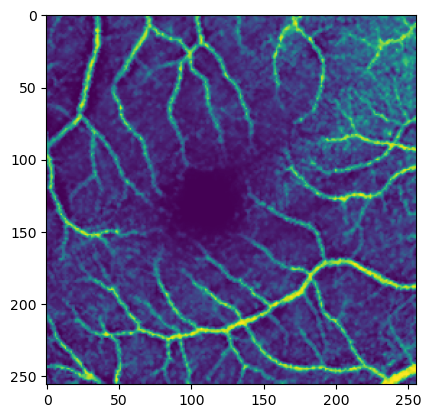

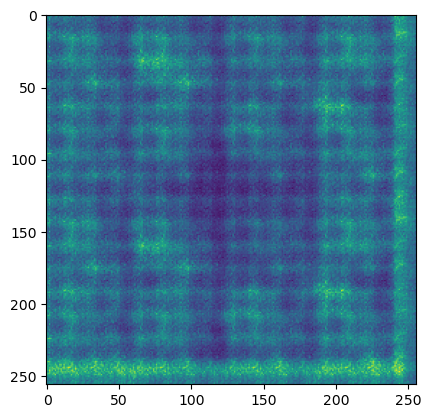

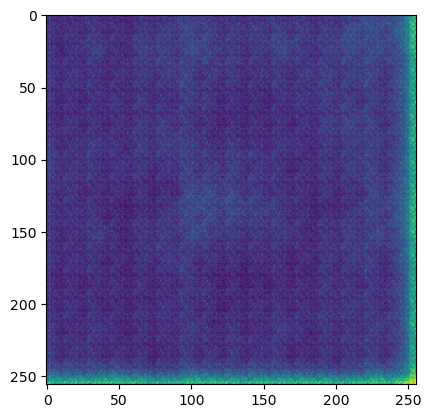

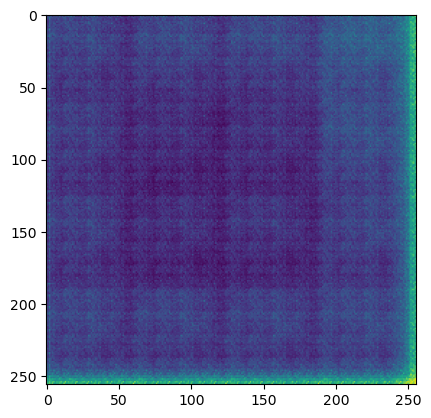

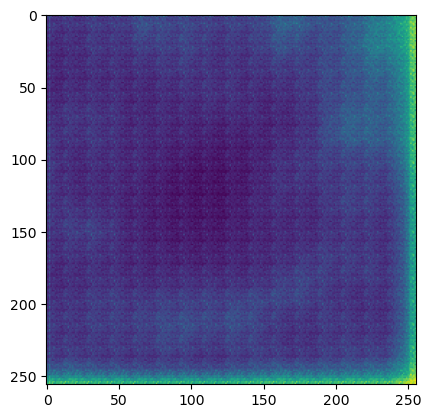

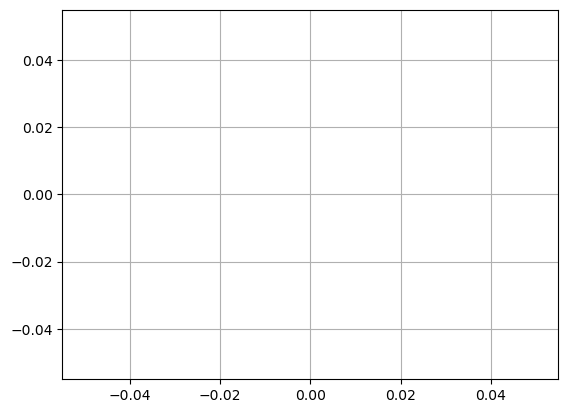


  0%|                                                                                            | 0/2 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [78]:
#####################Training loop ###########################

# args.mode = 1

for task_idx in tqdm(np.arange(args.num_tasks)):

    Enc = Enc_base

    Dec = Dec_aux_list[task_idx]
    Dec_name = Dec_name_list[task_idx]

    Train_Data  = Train_Data_list[task_idx]
    Target_Data = Target_Data_list[task_idx]
    args.num_batches = int(len(Train_Data)/args.N)

    args.training_mode = 1
    args.num_batches = int(len(Train_Data)/args.N)

    # RM_path_save = resume_AE_ckpt.joinpath('FAZ_RM_ckpt')

    args.num_epochs = 100
    args.show_example_epochs = 1
    args.save_epochs = 1

    log_mean_epoch_losses = np.zeros(args.num_epochs)

    loss = nn.BCELoss() # <-- Use this one
    loss2 = nn.L1Loss()

    lr = 1E-4
    params_list = list(Enc.parameters()) + list(Dec.parameters())
    optimizer = torch.optim.Adam(params_list, lr=lr, betas=(0.9, 0.999))
    
    one_hot_enc = torch.zeros(args.num_tasks).to(args.device)
    one_hot_enc[task_idx] = 1

    # train_dice_v = []
    # train_dice_v2 = []
    # test_dice_v = []
    # test_dice_v2 = []

    # Train for a maximum of max_epochs:
    for epoch in tqdm(np.arange(args.num_epochs), desc="Training progress..."):
        
        epoch_losses = single_epoch_AE(Train_Data, Target_Data, Enc, Dec, one_hot_enc, optimizer, loss, loss2, args)
        log_mean_epoch_losses[epoch] = np.log(np.mean(epoch_losses))
    #     coord_errors[epoch] = f_coord_error(train_data,train_data_traj,VPTR_Enc, C1, args)

        if np.mod(epoch,args.show_example_epochs) == 0:
            display_AE(Train_Data, Target_Data, Enc, Dec, one_hot_enc, args)

            plt.plot(log_mean_epoch_losses[0:epoch])
            plt.grid()
            plt.show()

    #         train_dice = f_Tot_Dice(Train_Data,args)
    #         print(train_dice)
    #         train_dice_v.append(train_dice)
    #         plt.plot(train_dice_v)
    #         plt.grid()
    #         plt.show()

    #         test_dice, test_dice2 = f_Tot_Dice(Test_Data,args)
    #         print(test_dice)
    #         print(test_dice2)
    #         test_dice_v.append(test_dice)
    #         test_dice_v2.append(test_dice2)
    #         plt.plot(test_dice_v)
    #         plt.plot(test_dice_v2)
    #         plt.grid()
    #         plt.show()

    #         plt.plot(coord_errors[0:epoch])
    #         plt.grid()
    #         plt.show()
    #     if np.mod(epoch,args.save_epochs) == 0:
    #         torch.save(model.state_dict(), RM_path_save)

#     Dec_aux_load = resume_AE_ckpt.joinpath(Dec_name)
#     torch.save(Dec.state_dict(), Dec_aux_load)

In [ ]:
# torch.save(Enc.state_dict(), Enc_base_load)
# torch.save(Enc.state_dict(), Dec_base_load)

# Dec_aux_load = resume_AE_ckpt.joinpath(Dec_name)
# torch.save(Dec.state_dict(), Dec_aux_load)

### Full training loop

In [ ]:
# params_list = list(Enc_base.parameters()) + list(Dec_base.parameters()) + list(Dec_aux_healthy_mask.parameters())

# params_list = list(Enc_base.parameters()) + list(Dec_base.parameters())
# for i in np.arange(args.num_tasks):
#     params_list += list(Dec_aux_list[i].parameters())

params_list = list(Enc_base.parameters()) + list(Dec_base.parameters())
optimizers = []
lr = 1E-4
for i in np.arange(args.num_tasks):
    params_list_i = params_list + list(Dec_aux_list[i].parameters())
    optimizer_i = torch.optim.Adam(params_list_i, lr=lr, betas=(0.9, 0.999))
    optimizers.append(optimizer_i)

In [ ]:
one_hot_enc_v = []
for task_idx in np.arange(args.num_tasks):
    one_hot = torch.zeros(args.num_tasks).to(args.device)
    one_hot[task_idx] = 1
    ones = torch.ones(args.batch_size,1,args.num_tasks).to(args.device)
    one_hot_enc = ones*one_hot

    one_hot_enc_v.append(one_hot_enc)

In [ ]:
np.zeros((10,5))

In [ ]:
#####################Training loop ###########################

# args.training_mode = 1

args.num_epochs = 1000
args.show_example_epochs = 1
args.save_epochs = 1

epoch_per_task = 1

mean_epoch_losses = np.zeros((args.num_tasks,args.num_epochs))
log_mean_epoch_losses = np.zeros((args.num_tasks,args.num_epochs))

loss = nn.BCELoss() # <-- Use this one
loss2 = nn.L1Loss()

# lr = 1E-4
# params_list = list(Enc_base.parameters()) + list(Dec_base.parameters())
# optimizer = torch.optim.Adam(params_list, lr=lr, betas=(0.9, 0.999))

# train_dice_v = []
# train_dice_v2 = []
# test_dice_v = []
# test_dice_v2 = []

# Train for a maximum of max_epochs:
for epoch in tqdm(np.arange(args.num_epochs), desc="Training progress..."):

    #################################
#     task_idx = np.random.choice(np.arange(args.num_tasks))
    task_idx = int(np.floor(np.mod(epoch,epoch_per_task*args.num_tasks)/epoch_per_task))
    print(task_idx)
    
    optimizer = optimizers[task_idx]
    one_hot_enc = one_hot_enc_v[task_idx]

    Train_Data  = Train_Data_list[task_idx]
    Target_Data = Target_Data_list[task_idx]
    Dec_i = Dec_aux_list[task_idx]
    args.num_batches = int(len(Train_Data)/args.N)
    #################################
    
    epoch_losses = single_epoch_FAZ(Train_Data, Target_Data, Enc_base, Dec_base, Dec_i, one_hot_enc, optimizer, loss, loss2, args, params_list_i)
    mean_epoch_loss = np.mean(epoch_losses)
    mean_epoch_losses[task_idx,epoch] = mean_epoch_loss
    log_mean_epoch_losses[task_idx,epoch] = np.log(mean_epoch_loss)
#     coord_errors[epoch] = f_coord_error(train_data,train_data_traj,VPTR_Enc, C1, args)
    
    if np.mod(epoch,args.show_example_epochs) == 0:
        display_FAZ(Train_Data, Target_Data, Enc_base, Dec_base, one_hot_enc, args)
        
        for task in np.arange(args.num_tasks):
            plt.plot(log_mean_epoch_losses[task,0:epoch])
            plt.grid()
            plt.show()
        
#         train_dice = f_Tot_Dice(Train_Data,args)
#         print(train_dice)
#         train_dice_v.append(train_dice)
#         plt.plot(train_dice_v)
#         plt.grid()
#         plt.show()
        
#         test_dice, test_dice2 = f_Tot_Dice(Test_Data,args)
#         print(test_dice)
#         print(test_dice2)
#         test_dice_v.append(test_dice)
#         test_dice_v2.append(test_dice2)
#         plt.plot(test_dice_v)
#         plt.plot(test_dice_v2)
#         plt.grid()
#         plt.show()
        
#         plt.plot(coord_errors[0:epoch])
#         plt.grid()
#         plt.show()
#     if np.mod(epoch,args.save_epochs) == 0:
#         torch.save(model.state_dict(), RM_path_save)

#     one_hot_enc[:,task_idx] = 0

In [ ]:
# -------------------------------